In [5]:
import torch
import pennylane as qml
import math
import matplotlib.pyplot as plt

In [3]:
def rotation_mat(a):
    """Given a fixed value 'a', compute the signal rotation matrix W(a).
    (requires -1 <= 'a' <= 1)
    """
    diag = a
    off_diag = (1 - a**2) ** (1 / 2) * 1j
    W = [[diag, off_diag], [off_diag, diag]]

    return W


def generate_many_sro(a_vals):
    """Given a tensor of possible 'a' vals, return a tensor of W(a)"""
    w_array = []
    for a in a_vals:
        w = rotation_mat(a)
        w_array.append(w)

    return torch.tensor(w_array, dtype=torch.complex64, requires_grad=False)

In [8]:
def QSP_circ(phi, W):
    qml.Hadamard(wires=0)
    for angle in phi[:-1]:
        qml.RZ(angle, wires=0)
        qml.QubitUnitary(W,wires=0)
    qml.RZ(phi[-1], wires=0)
    qml.Hadamard(wires=0)
    return



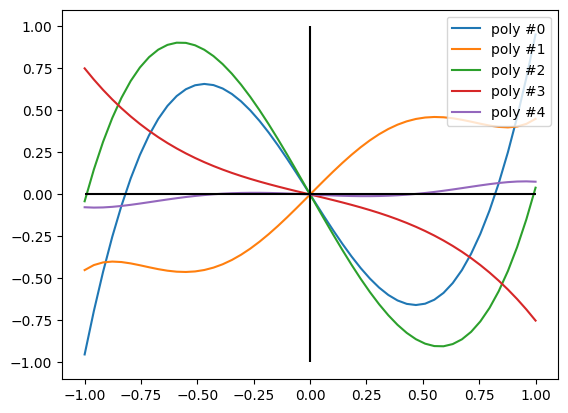

In [10]:
d = 5
a_vals = torch.linspace(-1, 1, 50)
w_mats = generate_many_sro(a_vals)

gen = torch.Generator()
gen.manual_seed(444422)  # set random seed for reproducibility

for i in range(5):
    phi = torch.rand(d + 1, generator=gen) * 2 * torch.tensor([math.pi], requires_grad=False)
    matrix_func = qml.matrix(QSP_circ, wire_order=[0])
    y_vals = [matrix_func(phi, w)[0, 0].real for w in w_mats]

    plt.plot(a_vals, y_vals, label=f"poly #{i}")

plt.vlines(0.0, -1.0, 1.0, color="black")
plt.hlines(0.0, -1.0, 1.0, color="black")
plt.legend(loc=1)
plt.show()


# Function fitting with QSP

In [11]:
torch_pi = torch.Tensor([math.pi])


class QSP_Func_Fit(torch.nn.Module):
    def __init__(self, degree, num_vals, random_seed=None):
        """Given the degree and number of samples, this method randomly
        initializes the parameter vector (randomness can be set by random_seed)
        """
        super().__init__()
        if random_seed is None:
            self.phi = torch_pi * torch.rand(degree + 1, requires_grad=True)

        else:
            gen = torch.Generator()
            gen.manual_seed(random_seed)
            self.phi = torch_pi * torch.rand(degree + 1, requires_grad=True, generator=gen)

        self.phi = torch.nn.Parameter(self.phi)
        self.num_phi = degree + 1
        self.num_vals = num_vals

    def forward(self, omega_mats):
        """PennyLane forward implementation"""
        y_pred = []
        generate_qsp_mat = qml.matrix(QSP_circ, wire_order=[0])

        for w in omega_mats:
            u_qsp = generate_qsp_mat(self.phi, w)
            P_a = u_qsp[0, 0]  # Taking the (0,0) entry of the matrix corresponds to <0|U|0>
            y_pred.append(P_a.real)

        return torch.stack(y_pred, 0)

class Model_Runner:
    def __init__(self, model, degree, num_samples, x_vals, process_x_vals, y_true):
        """Given a model and a series of model specific arguments, store everything in
        internal attributes.
        """
        self.model = model
        self.degree = degree
        self.num_samples = num_samples

        self.x_vals = x_vals
        self.inp = process_x_vals(x_vals)
        self.y_true = y_true

    def execute(
        self, random_seed=13_02_1967, max_shots=25000, verbose=True
    ):  # easter egg: oddly specific seed?
        """Run the optimization protocol on the model using Mean Square Error as a loss
        function and using stochastic gradient descent as the optimizer.
        """
        model = self.model(degree=self.degree, num_vals=self.num_samples, random_seed=random_seed)

        criterion = torch.nn.MSELoss(reduction="sum")
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)

        t = 0
        loss_val = 1.0

        while (t <= max_shots) and (loss_val > 0.5):

            self.y_pred = model(self.inp)

            if t == 1:
                self.init_y_pred = self.y_pred

            # Compute and print loss
            loss = criterion(self.y_pred, self.y_true)
            loss_val = loss.item()

            if (t % 1000 == 0) and verbose:
                print(f"---- iter: {t}, loss: {round(loss_val, 4)} -----")

            # Perform a backward pass and update weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            t += 1

        self.model_params = model.phi

    def plot_result(self, show=True):
        """Plot the results"""
        plt.plot(self.x_vals, self.y_true.tolist(), "--b", label="target func")
        plt.plot(self.x_vals, self.y_pred.tolist(), ".g", label="optim params")
        plt.plot(self.x_vals, self.init_y_pred.tolist(), ".r", label="init params")
        plt.legend(loc=1)

        if show:
            plt.show()



---- iter: 0, loss: 13.5938 -----
---- iter: 1000, loss: 11.8809 -----
---- iter: 2000, loss: 10.229 -----
---- iter: 3000, loss: 8.6693 -----
---- iter: 4000, loss: 7.2557 -----
---- iter: 5000, loss: 6.0084 -----
---- iter: 6000, loss: 4.9197 -----
---- iter: 7000, loss: 3.9801 -----
---- iter: 8000, loss: 3.1857 -----
---- iter: 9000, loss: 2.5312 -----
---- iter: 10000, loss: 2.0045 -----
---- iter: 11000, loss: 1.5873 -----
---- iter: 12000, loss: 1.2594 -----
---- iter: 13000, loss: 1.0021 -----
---- iter: 14000, loss: 0.7997 -----
---- iter: 15000, loss: 0.6397 -----
---- iter: 16000, loss: 0.5127 -----


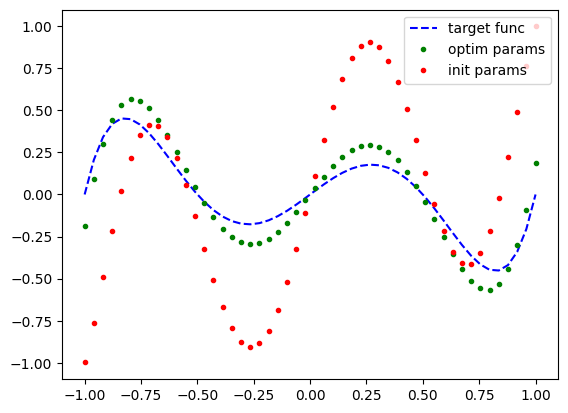

In [12]:
import numpy as np

d = 9  # dim(phi) = d + 1,
num_samples = 50


def custom_poly(x):
    """A custom polynomial of degree <= d and parity d % 2"""
    return torch.tensor(4 * x**5 - 5 * x**3 + x, requires_grad=False, dtype=torch.float)


a_vals = np.linspace(-1, 1, num_samples)
y_true = custom_poly(a_vals)

qsp_model_runner = Model_Runner(QSP_Func_Fit, d, num_samples, a_vals, generate_many_sro, y_true)

qsp_model_runner.execute()
qsp_model_runner.plot_result()